In [1]:
import functools
from os import path

from absl import app
from absl import flags
import flax
from flax.metrics import tensorboard
from flax.training import checkpoints
import jax
from jax import random
import numpy as np

from jaxnerf.nerf import datasets
from jaxnerf.nerf import models
from jaxnerf.nerf import utils

In [73]:
class FLAGS:
    train_dir = '/home/ubuntu/models/jaxnerf_models/blender/ship'
    data_dir = '/home/ubuntu/data/nerf_synthetic/ship'
    config = 'configs/blender'
    
    dataset = 'blender'
    batching = 'single_image'
    white_bkgd = True
    batch_size = 1024
    factor = 2
    spherify = False
    render_path = False
    llffhold = 8
    use_pixel_centers = False
    model = 'nerf'
    near = 2.
    far = 6.
    net_depth = 8
    net_width = 256
    net_depth_condition = 1
    net_width_condition = 128
    weight_decay_mult = 0
    skip_layer = 4
    num_rgb_channels = 3
    num_sigma_channels = 1
    randomized = True
    min_deg_point = 0
    max_deg_point = 10
    deg_view = 4
    num_coarse_samples = 64
    num_fine_samples = 128
    use_viewdirs = True
    noise_std = None
    lindisp = False
    net_activation = 'relu'
    rgb_activation = 'sigmoid'
    sigma_activation = 'relu'
    legacy_posenc_order = False
    
    lr_init = 5e-4
    lr_final = 5e-6
    lr_delay_steps = 0
    lr_delay_mult = 1.
    grad_max_norm = 0.
    grad_max_val = 0.
    max_steps = 1000000
    save_every = 10000
    print_every = 100
    render_every = 5000
    gc_every = 10000
    
    eval_once = True
    save_output = True
    chunk = 4096

rng = random.PRNGKey(20200823)

dataset = datasets.get_dataset("test", FLAGS)
rng, key = random.split(rng)
model, init_variables = models.get_model(key, dataset.peek(), FLAGS)
optimizer = flax.optim.Adam(FLAGS.lr_init).create(init_variables)
state = utils.TrainState(optimizer=optimizer)
del optimizer, init_variables

# Rendering is forced to be deterministic even if training was randomized, as
# this eliminates "speckle" artifacts.
def render_fn(variables, key_0, key_1, rays):
    return jax.lax.all_gather(
        model.apply(variables, key_0, key_1, rays, False), axis_name="batch")

# pmap over only the data input.
render_pfn = jax.pmap(
  render_fn,
  in_axes=(None, None, None, 0),
  donate_argnums=3,
  axis_name="batch",
)

state = checkpoints.restore_checkpoint(FLAGS.train_dir, state)

/home/ubuntu/.conda/envs/cs184/lib/python3.8/site-packages/flax/optim/base.py:49: DeprecationWarning: Use `optax` instead of `flax.optim`. Refer to the update guide https://flax.readthedocs.io/en/latest/howtos/optax_update_guide.html for detailed instructions.
  warnings.warn(


In [74]:
for _ in range(40):
    batch = next(dataset)

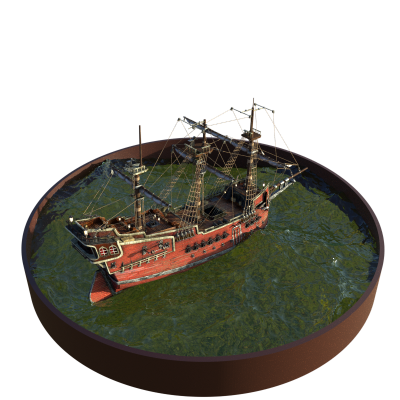

In [75]:
from PIL import Image
Image.fromarray(np.array(batch['pixels'] * 255, dtype=np.uint8))

In [76]:
pred_color, pred_disp, pred_acc, pred_sigma, pred_rgb = utils.render_image(
    functools.partial(render_pfn, state.optimizer.target),
    batch["rays"],
    rng,
    FLAGS.dataset == "llff",
    chunk=FLAGS.chunk)

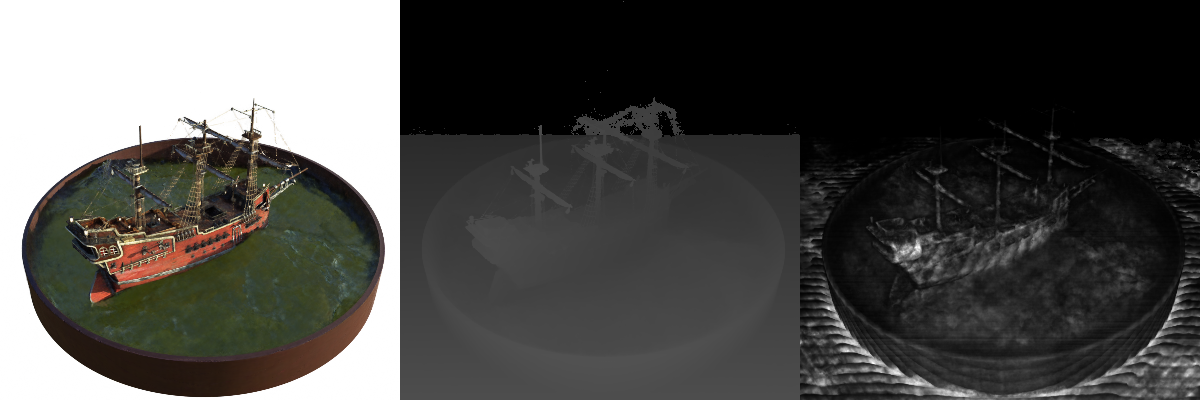

In [77]:
def concat_img_horizontal(ims):
    dst = Image.new('RGB', (ims[0].width * len(ims), ims[0].height))
    for i, im in enumerate(ims):
        dst.paste(im, (i * im.width, 0))
    return dst

def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

color_im = Image.fromarray(np.array(pred_color * 255, dtype=np.uint8))
disp_im = Image.fromarray(np.array(pred_disp.squeeze() * 255, dtype=np.uint8))
acc_im = Image.fromarray(np.array(pred_acc.squeeze() * 255, dtype=np.uint8))
s_im = Image.fromarray(np.array(normalize(pred_sigma.mean(-1)) * 255, dtype=np.uint8))
concat_img_horizontal([color_im, disp_im, s_im])

In [78]:
t = np.linspace(-1.2, 1.2, 256)
query_pts = np.stack(np.meshgrid(t, t, t), -1).astype(np.float32)
query_pts.shape

(256, 256, 256, 3)

In [79]:
from tqdm import tqdm

tensors = []
for i in tqdm(range(len(query_pts))):
    frame = query_pts[:, i].transpose(1, 0, 2)
    z = utils.Rays(origins=frame, directions=np.zeros_like(frame), viewdirs=np.zeros_like(frame))

    pred_color, pred_disp, pred_acc, pred_sigma, pred_rgb = utils.render_image(
              functools.partial(render_pfn, state.optimizer.target),
              z,
              rng,
              FLAGS.dataset == "llff",
              chunk=FLAGS.chunk)
    tensors.append((np.array(pred_disp), 
                    np.array(pred_sigma),
                    np.array(pred_rgb)))

100%|█████████████████████████████████████████████████████████████████████████████████| 256/256 [03:27<00:00,  1.23it/s]


In [80]:
len(tensors)

256

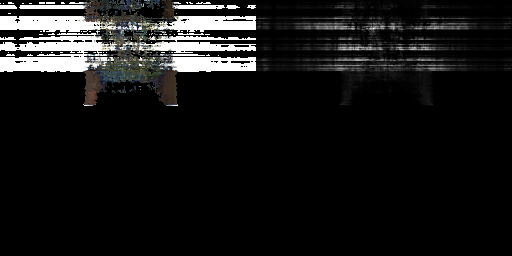

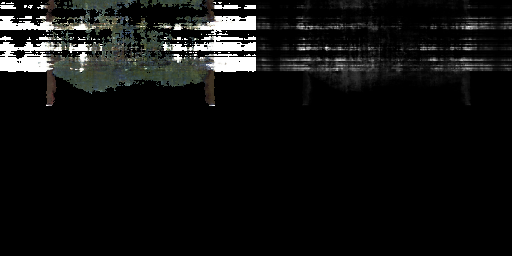

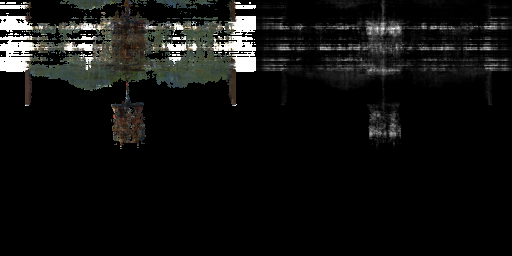

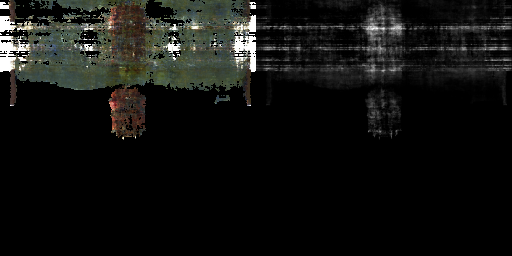

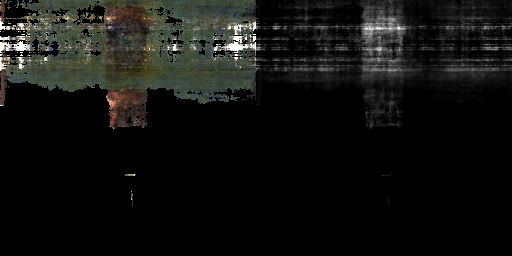

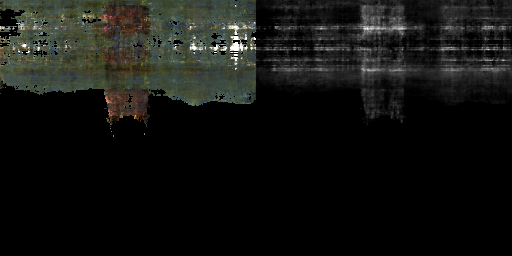

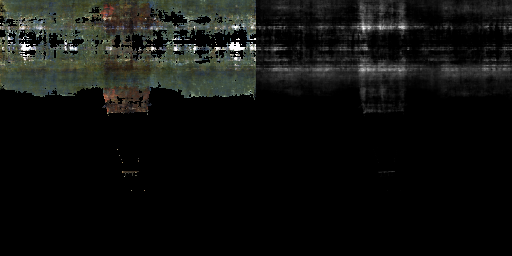

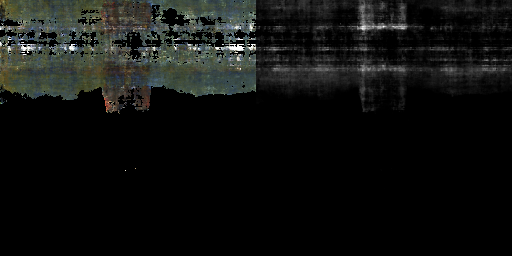

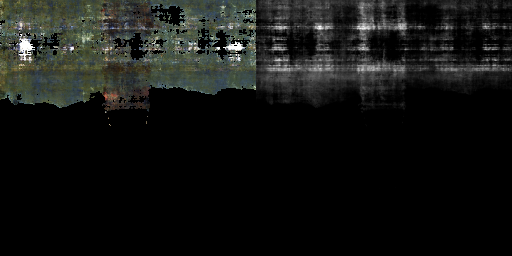

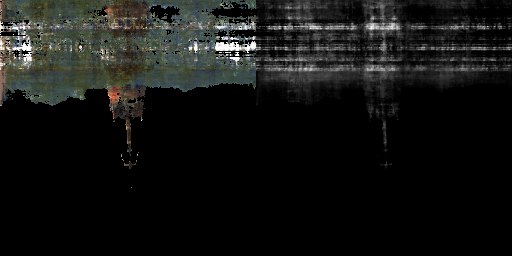

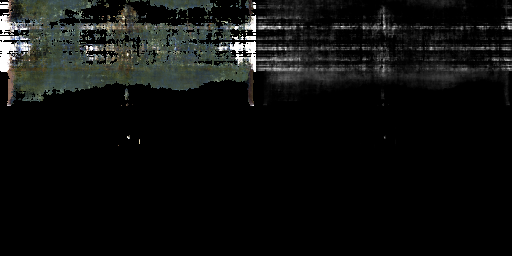

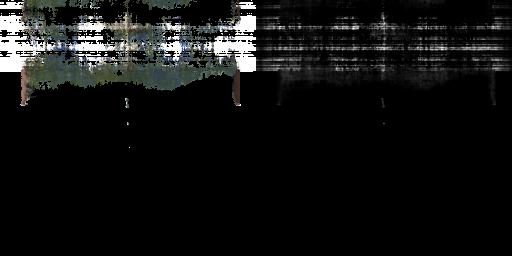

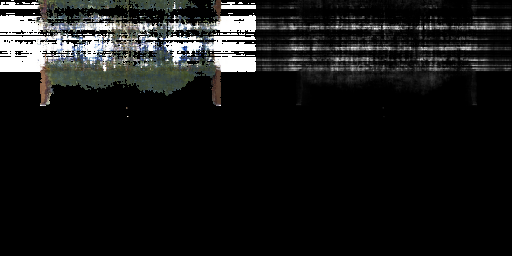

In [81]:
for (pred_disp, pred_sigma, pred_rgb) in tensors[::20]:
    pred_sigma = np.maximum(pred_sigma[...,-1], 0.)
    pred_rgb = pred_rgb.reshape(*pred_sigma.shape, 192, 3)[:, :, 0, :]
    
    disp_im = Image.fromarray(np.array(pred_disp.squeeze() * 255, dtype=np.uint8))
    rgb_im = Image.fromarray(np.array((pred_rgb * (normalize(pred_sigma)[:, :, None] > 1e-2)) * 255, dtype=np.uint8))
    
    s_im = Image.fromarray(np.array(normalize(pred_sigma) * 255, dtype=np.uint8))
    display(concat_img_horizontal([rgb_im, s_im]))

In [82]:
sigma = []
for (pred_disp, pred_sigma, pred_rgb) in tensors:
    pred_sigma = np.maximum(pred_sigma[...,-1], 0.)
    sigma.append(pred_sigma)
    
sigma = np.stack(sigma)

In [83]:
sigma.max()

4617.857

In [84]:
import mcubes

In [85]:
threshold = 50.
print('fraction occupied', np.mean(sigma > threshold))
vertices, triangles = mcubes.marching_cubes(sigma, threshold)
print('done', vertices.shape, triangles.shape)

fraction occupied 0.2738770842552185
done (1800344, 3) (3564918, 3)


In [ ]:
import trimesh

mesh = trimesh.Trimesh(vertices, triangles)
mesh.show()

In [69]:
import ipyvolume as ipv
import numpy as np
x, y, z = vertices[:, 0], vertices[:, 1], vertices[:, 2]

In [70]:
colors = []
for (pred_disp, pred_sigma, pred_rgb) in tensors:
    pred_rgb = pred_rgb.reshape(256, 256, 192, 3)[:, :, 0, :]
    colors.append(pred_rgb)
    
colors = np.stack(colors)

In [71]:
qx = np.floor(x).astype(np.uint8)
qy = np.floor(y).astype(np.uint8)
qz = np.floor(z).astype(np.uint8)

In [72]:
idx = np.random.choice(len(x), size=50000, replace=False)
fig = ipv.figure()
scatter = ipv.scatter(x[idx], y[idx], z[idx], color=colors[qx, qy, qz][idx, :], marker='sphere', size=0.8)
ipv.show()